In [1]:
from __future__ import print_function

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import datetime as datetime

import numpy as np
np.random.seed(1337)

<h2> Import Data </h2>

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)

(60000, 28, 28)


In [3]:
img_rows, img_cols = 28, 28

x_train_reshape = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test_reshape = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [4]:
# input image dimensions
x_train_reshape = x_train_reshape.astype('float32')
x_test_reshape = x_test_reshape.astype('float32')

x_train_reshape /= 255
x_test_reshape /= 255

print('x_train shape:', x_train.shape)
print(x_train_reshape.shape[0], 'train samples')
print(x_test_reshape.shape[0], 'test samples')

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [5]:
# convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test =to_categorical(y_test, 10)

<h2> Build Network </h2>

In [6]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,
                 kernel_initializer='he_normal',))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=['accuracy'])

history= model.fit(x_train_reshape, y_train,
          epochs=5,
          validation_data=(x_test_reshape, y_test)                  )

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 11s 183us/sample - loss: 0.1576 - accuracy: 0.9533 - val_loss: 0.0857 - val_accuracy: 0.9729
Epoch 2/5
60000/60000 [==============================] - 8s 139us/sample - loss: 0.0558 - accuracy: 0.9839 - val_loss: 0.0657 - val_accuracy: 0.9795
Epoch 3/5
60000/60000 [==============================] - 8s 136us/sample - loss: 0.0352 - accuracy: 0.9890 - val_loss: 0.0612 - val_accuracy: 0.9811
Epoch 4/5
60000/60000 [==============================] - 8s 134us/sample - loss: 0.0233 - accuracy: 0.9930 - val_loss: 0.0657 - val_accuracy: 0.9804
Epoch 5/5
60000/60000 [==============================] - 8s 135us/sample - loss: 0.0150 - accuracy: 0.9952 - val_loss: 0.0770 - val_accuracy: 0.9784


In [7]:
score = model.evaluate(x_test_reshape, y_test, verbose=0)

print(model.summary())
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                216330    
Total params: 216,650
Trainable params: 216,650
Non-trainable params: 0
_________________________________________________________________
None
Test loss: 0.0770171301567112
Test accuracy: 0.9784


<h2> Prune some filters to reduce parameters </h2>

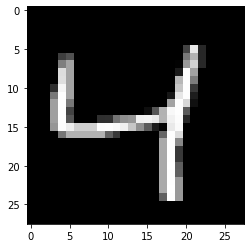

In [8]:
from tensorflow.keras.models import Model

# Extract an image and visualize its value

sample_mnsit = x_train[2]
plt.imshow(sample_mnsit, cmap='gray')
plt.show()

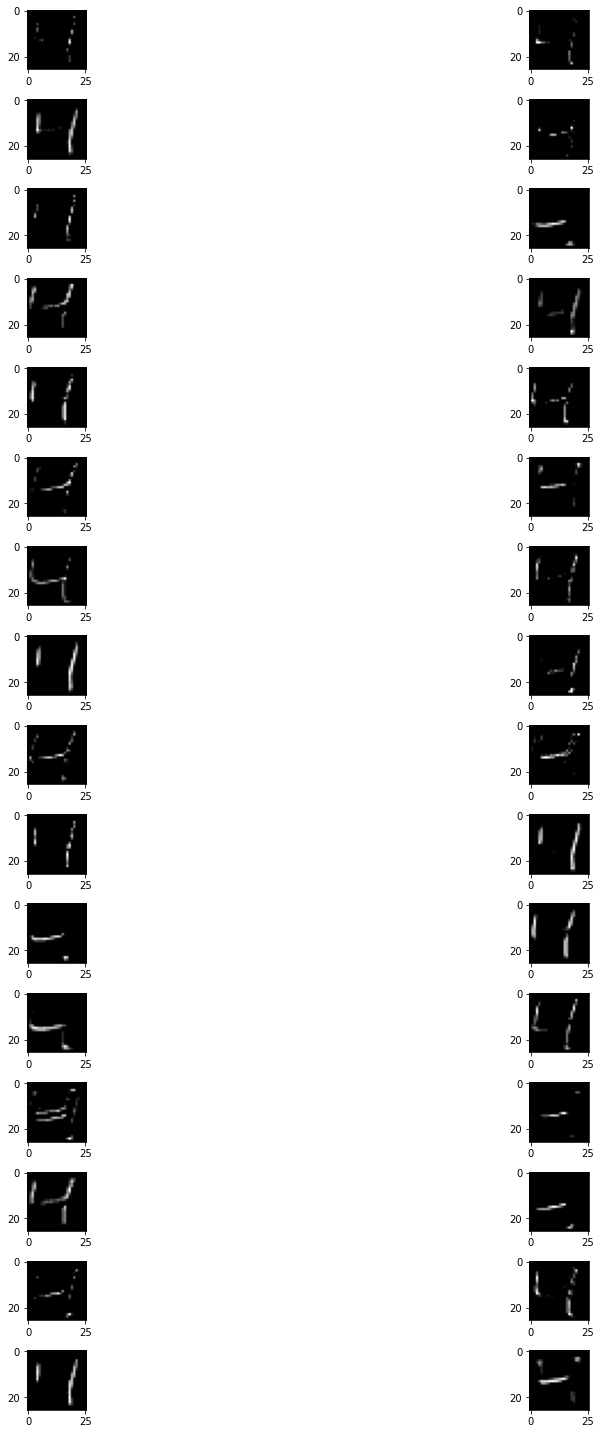

In [9]:
# Visualizes the filters created from the model

# fresh copy of image
sample_mnsit = x_train[2]

# Reshape to fit classifier
sample_mnsit = sample_mnsit.reshape(1, img_rows, img_cols, 1)

#Convert to flaot32
sample_mnsit = sample_mnsit.astype('float32')

# Normalizr features
sample_mnsit /= 255

# Input layer number you want to extract the feature maps from
layer_no = 0

# Get the filters from the first layer
modified_model = Model(inputs=model.inputs, outputs=model.layers[layer_no].output)

# Apply filters to image to get activation function
feature_maps  = modified_model.predict(sample_mnsit)

# Plot graph of each feature map
nrows = int(feature_maps.shape[-1] / 2)
ncols = 2
fig, axs = plt.subplots(nrows,ncols, 
                        figsize=(20, 20), 
                        facecolor='w', 
                        edgecolor='k',
                       )

axs = axs.ravel()


for i in range(feature_maps.shape[-1]):

    axs[i].imshow(feature_maps[0, :, :, i], cmap='gray')

plt.tight_layout(True)
plt.show()

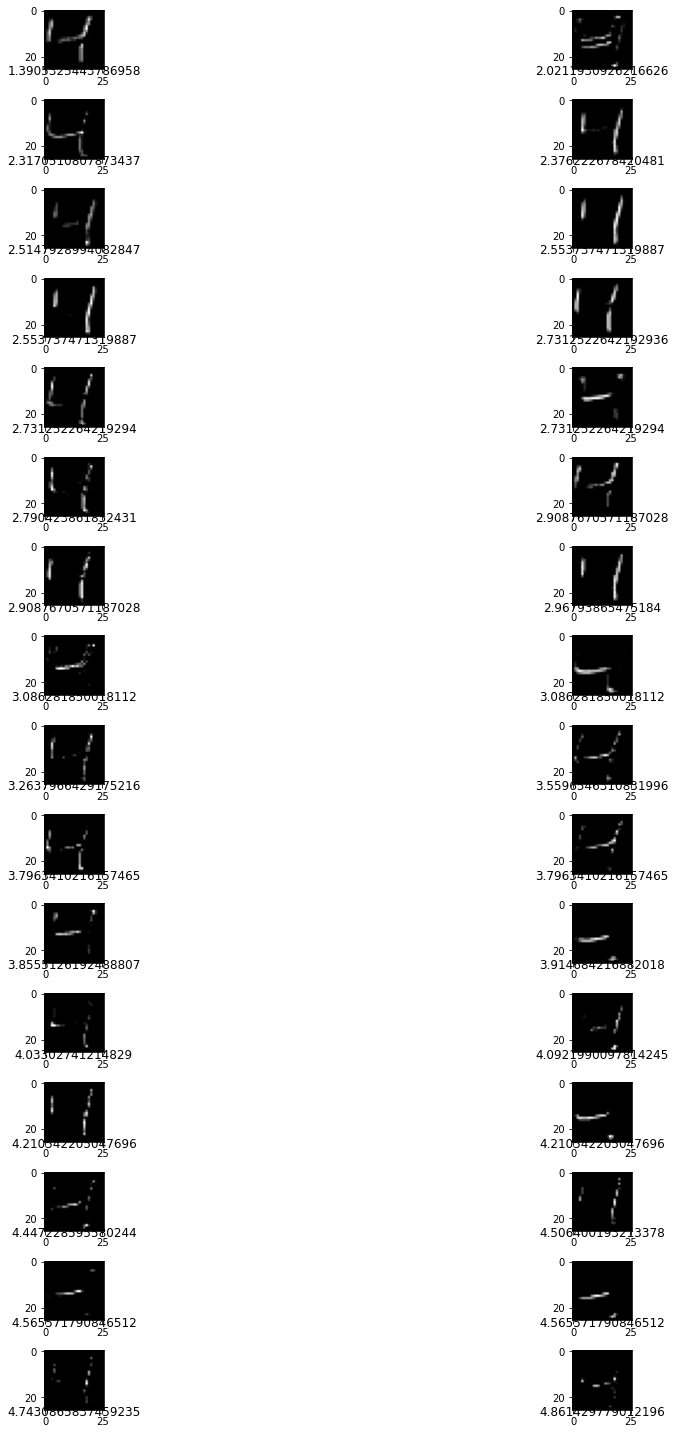

In [10]:
# Show most to least contributing filters

import cv2, numpy as np
from sklearn.cluster import KMeans

# Get the top dominat colors by percentage
def get_cluser(image):
    reshape = image.reshape((image.shape[0] * image.shape[1], 1))
    cluster = KMeans(n_clusters=5).fit(reshape)
    
    return cluster, cluster.cluster_centers_


def visualize_colors(image):
    
    cluster, centroids = get_cluser(image)
    # Get the number of different clusters, create histogram, and normalize
    labels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
    (hist, _) = np.histogram(cluster.labels_, bins = labels)
    hist = hist.astype("float")
    hist /= hist.sum()

    # Create frequency rect and iterate through each cluster's color and percentage
    colors = sorted([(percent, color) for (percent, color) in zip(hist, centroids)])
    
    return [percent*100 for (percent, color) in colors]
        


# Get the top 5 dominant color of the original image
original_image = visualize_colors(x_train[2])

# Get the top 5 dominant colors of the feature maps, subtract from original image
# Get mean value of the 5 differnce 

mean_value_diff = []
for x in range(feature_maps.shape[-1]):
    feature_map = visualize_colors(feature_maps[0, :, :, x])
    mean_value_diff.append(np.mean([np.abs(a_i - b_i) for a_i, b_i in zip(original_image, feature_map)]))
    
# values of sorted top feature maps
top_similair_features_values= sorted(mean_value_diff)

# index of sorted top feature maps with similiar value
top_similair_features_index = sorted(range(len(mean_value_diff)), key=lambda k: mean_value_diff[k])


# Plot top similiar features with original image
fig, axs = plt.subplots(nrows,ncols, 
                        figsize=(20, 20), 
                        facecolor='w', 
                        edgecolor='k',
                       )

axs = axs.ravel()



for i in range(feature_maps.shape[-1]):

    axs[i].imshow(feature_maps[0, :, :, top_similair_features_index[i]], cmap='gray')
    axs[i].text(0.5,-0.1, top_similair_features_values[i], size=12, ha="center", 
             transform=axs[i].transAxes)
plt.tight_layout(True)
plt.show()


In [11]:
# Decided to delete 
print(f"Feature index for most contributing to less contributing {top_similair_features_index}")

Feature index for most contributing to less contributing [26, 24, 12, 2, 7, 14, 19, 21, 23, 31, 29, 6, 8, 30, 17, 22, 13, 16, 9, 10, 11, 5, 1, 15, 18, 20, 28, 4, 25, 27, 0, 3]


In [12]:
# Delete filter index 1 and 3 filter since they are least contribyting
#print("--Before--")
#print(model.summary())

# Delete from the conv layer
w,b = model.layers[0].get_weights()
print("--Before--")
print(w.shape)
print(b.shape)

w = np.delete(w, [31], -1)
b = np.delete(b, [31], 0)
print("--after--")
print(w.shape)
print(b.shape)

# Delete from the FC layer
w_2,b_2 = model.layers[2].get_weights()
w_2 = w_2[:20956,:]
#b_2 = np.delete(b, [3], 0)

#model.layers[0].set_weights([w,b])

--Before--
(3, 3, 1, 32)
(32,)
--after--
(3, 3, 1, 31)
(31,)


<h2> Build New proned network </h2>

In [13]:
# Input stays the same
model_1 = Sequential()

# New modified conv layer
model_1.add(Conv2D(31, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,
                 kernel_initializer='he_normal',trainable=False))

model_1.add(Flatten(trainable=False))
model_1.add(Dense(10, activation='softmax',trainable=False))



model_1.layers[0].set_weights([w,b])
model_1.layers[2].set_weights([w_2,b_2])

model_1.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=['accuracy'])


print(model_1.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 31)        310       
_________________________________________________________________
flatten_1 (Flatten)          (None, 20956)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                209570    
Total params: 209,880
Trainable params: 0
Non-trainable params: 209,880
_________________________________________________________________
None


In [14]:
score = model_1.evaluate(x_test_reshape, y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 131us/sample - loss: 5.2946 - accuracy: 0.1736
Test loss: 5.294643531799316
Test accuracy: 0.1736


In [15]:
model_1.layers[0].get_weights()[0] == model.layers[0].get_weights()[0][:,:,:,:31]

array([[[[ True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True]],

        [[ True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True]],

        [[ True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True]]],


       [[[ True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,
           True,  Tr

In [21]:
if model_1.layers[2].get_weights()[0].all() == model.layers[2].get_weights()[0][:20956,:].all() :
    print("True")

True
